##BankTermPredict: Predicting Client Subscription to Term Deposits from Campaign Data

Exploratory Data Analysis  
Source:  https://archive.ics.uci.edu/dataset/222/bank+marketing  
Greg Gibson Sept. 2025

This notebook will perform the following EDA tasks:
- Load the dataset and explore its structure
- Handle missing values, duplicates, and data types
- Analyze distributions of key features (age, balance, campaign, etc.)
- Check for target class imbalance (`y` variable)
- Summarize insights with visualizations (histograms, boxplots, correlation heatmaps)


Clarifications:
- campaign - number of contacts performed to the client during this campaign
- previous - number of contacts performed to the client before this campaign
- pdays    - number of days that passed by after the client was last contacted from a previous campaign (-1 means not previously contacted)
- poutcome - outcome of the previous marketing campaign

Observations:

- Target column is named 'y', representing whether customer subscribed to a term deposit
- 16 features, 45k entries, no missing values
- 3 yes/no, 5 categorical, 6 integers plus day number of the month and three-letter month abbreviation (no year)
- No duplicate rows
- Negative values in balance (customer owed credit?) and pdays (-1 means customer not previously contacted)
- The'previous' column max of 275 is a distant outlier

Findings:

- Target column is yes/no and unbalanced, being under 12% 'yes'
- Who says 'yes' more proportionally?  
    - Students & retirees, single, more education, no loans, no defaults, or contacted in Mar, Sept, Oct, Dec
- In poutcome column regarding previous campaign, nearly 40% of 'success' did not convert in current campaign, and 10% of previous 'failure' did
- Heavy skewing of balance, campaign, duration, age is closer to normally distributed; will apply caps and robust scaling to minimize outliers on models
- Only pdays and previous columns have some correlation (days since prior contact from previous campaign, number of contacts to client performed in prior campaign)  
    - Only 18% of customers were contacted during the previous campaign per the pdays column; this can become a binary flag
- Drop duration - as noted, this is unknown until call has ended and target already determined, non-predictive

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, normaltest

# Custom preprocessing functions
from pipeline.preprocessor import YesNoEncoder

## Import and Basic Layout

In [2]:
df = pd.read_csv("../data/bank-full.csv", sep=";")

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Note: there are no null values

In [5]:
# Numerical columns statistics
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


Note: Day is day number of month and pdays -1 means customer not previously contacted

In [6]:
# pdays group counts
print(f"-1:", df['pdays'][df['pdays']<0].count())
print(f"=0:", df['pdays'][df['pdays']==0].count())
print(f">0:", df['pdays'][df['pdays']>0].count())

-1: 36954
=0: 0
>0: 8257


In [7]:
# List unique values for each categorical column
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    print(f"Unique values in '{col}':")
    print(df[col].unique())
    print('-' * 40)

Unique values in 'job':
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
----------------------------------------
Unique values in 'marital':
['married' 'single' 'divorced']
----------------------------------------
Unique values in 'education':
['tertiary' 'secondary' 'unknown' 'primary']
----------------------------------------
Unique values in 'default':
['no' 'yes']
----------------------------------------
Unique values in 'housing':
['yes' 'no']
----------------------------------------
Unique values in 'loan':
['no' 'yes']
----------------------------------------
Unique values in 'contact':
['unknown' 'cellular' 'telephone']
----------------------------------------
Unique values in 'month':
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
----------------------------------------
Unique values in 'poutcome':
['unknown' 'failure' 'other' 'success']
-----------

In [18]:
# Column groups
yes_no_cols = ['default', 'housing', 'loan', 'y']
ord_col = ['education']
ord_map = [['unknown', 'primary', 'secondary', 'tertiary']]

cat_cols = ['job', 'marital', 'contact', 'month', 'poutcome']
num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

### Proportions

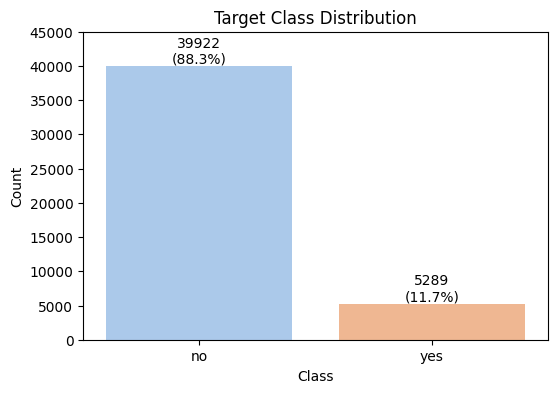

In [9]:
# Check for target class imbalance
class_counts = df['y'].value_counts()

# Percentages of total
total = class_counts.sum()
percentages = (class_counts / total) * 100

# Plot
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    x=class_counts.index.astype(str),
    y=class_counts.values,
    palette='pastel',
    hue=class_counts.index.astype(str),
    legend=False
)
plt.title('Target Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# Annotate counts and percentages above bars
for i, (val, pct) in enumerate(zip(class_counts.values, percentages.values)):
    ax.text(i, val + (0.01 * total), f"{val}\n({pct:.1f}%)", ha='center')

ax.set_ylim(0, 45000) # set y-axis limit for better annotation visibility
plt.show()

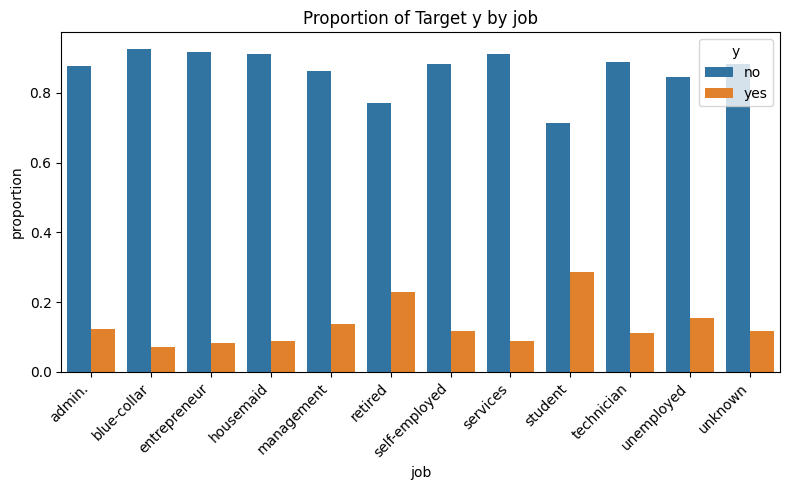

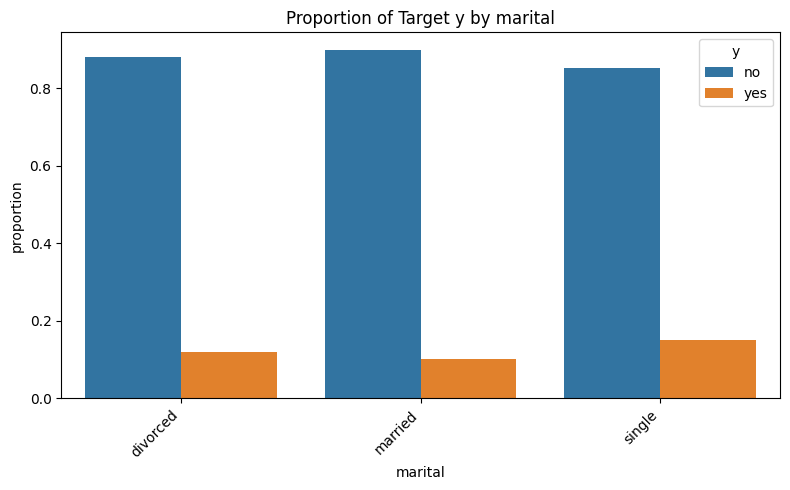

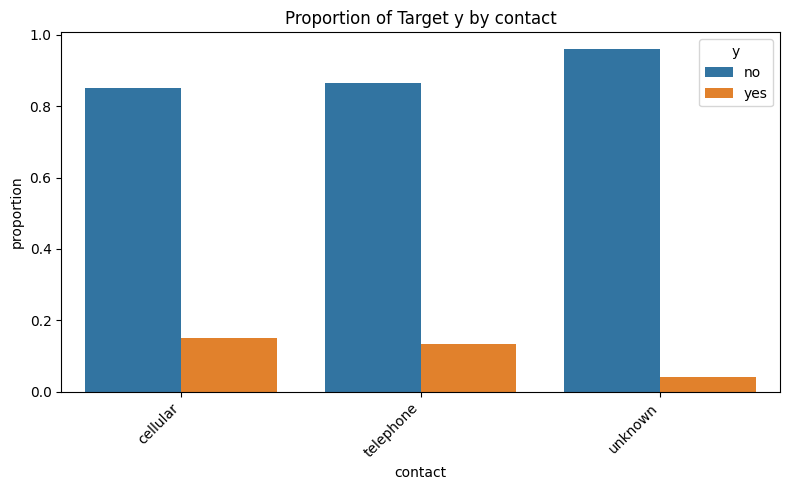

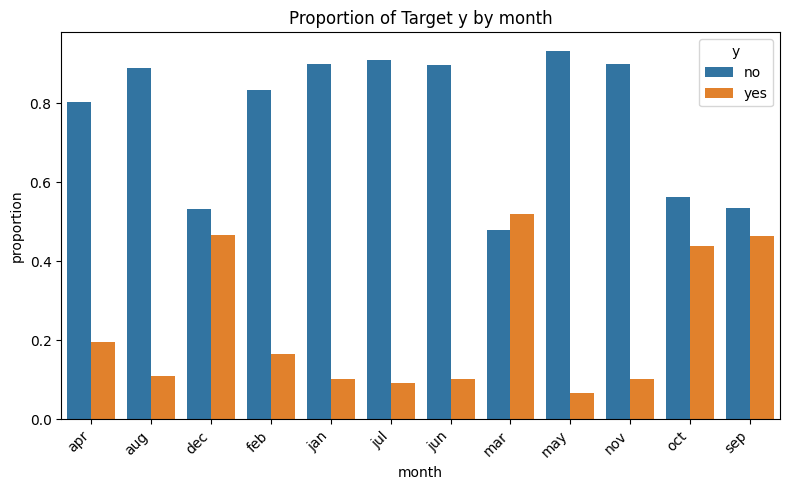

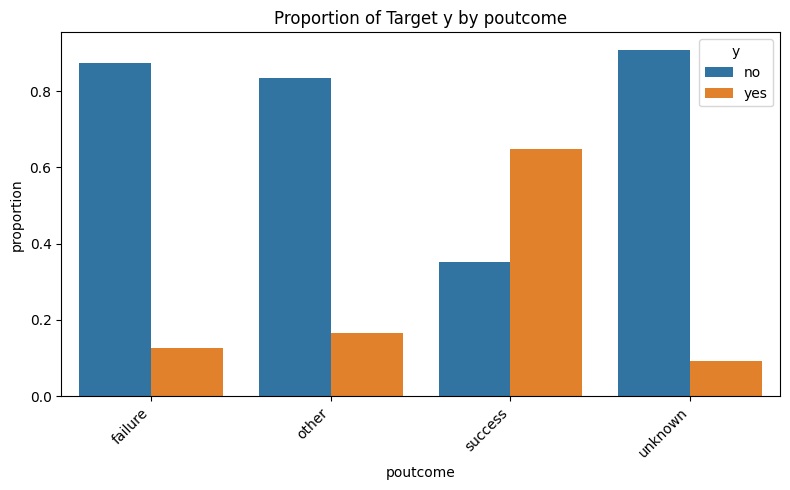

In [10]:
# Loop through categorical variables and plot proportions
for col in cat_cols:
    plt.figure(figsize=(8, 5))
    
    proportions = (
        df.groupby(col)["y"]
               .value_counts(normalize=True)
               .rename("proportion")
               .reset_index()
    )
    
    sns.barplot(data=proportions, x=col, y="proportion", hue="y")
    plt.title(f"Proportion of Target y by {col}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

## Data Quality

### yes/no to binary

In [11]:
# yes/no to binary (default, housing, loan, y)
for col in yes_no_cols:
    df[col] = df[col].map({'yes': 1, 'no': 0})

In [12]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0


In [13]:
# Split target and features
y = df['y']
X = df.drop(columns=['y'])

###Duplicate values

In [14]:
print('Number of duplicate rows in features:', X.duplicated().sum())

Number of duplicate rows in features: 0


### Distributions & Outliers

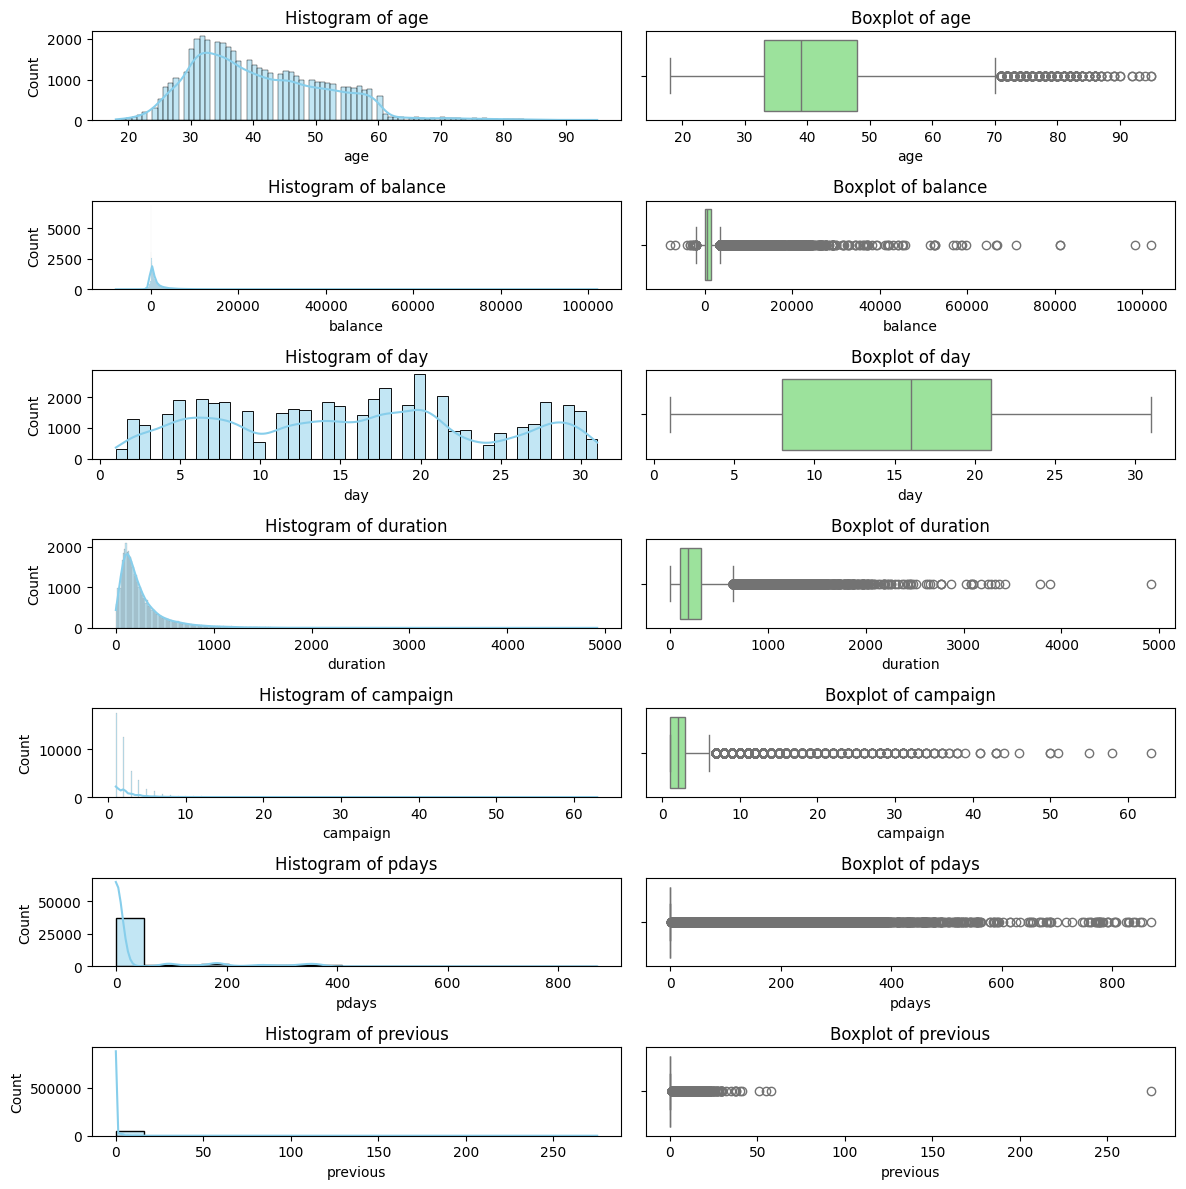

In [15]:
# Analyze distributions of numerical features
fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 12))
for i, feature in enumerate(num_cols):
    sns.histplot(X[feature], kde=True, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f'Histogram of {feature}')
    sns.boxplot(x=X[feature], ax=axes[i, 1], color='lightgreen')
    axes[i, 1].set_title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

In [16]:
# Identify outliers in numeric features using IQR and z-score methods

outlier_summary = {}

for col in num_cols:
    data = X[col]
    # IQR method
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    iqr_outliers = ((data < lower_bound) | (data > upper_bound)).sum()
    # Z-score method
    z_scores = zscore(data)
    z_outliers = (abs(z_scores) > 3).sum()
    outlier_summary[col] = {
        'IQR_outliers': iqr_outliers,
        'Zscore_outliers': z_outliers,
        'Total': len(data)
    }

# Display outlier summary
outlier_df = pd.DataFrame(outlier_summary).T
outlier_df['IQR_%'] = 100 * outlier_df['IQR_outliers'] / outlier_df['Total']
outlier_df['Zscore_%'] = 100 * outlier_df['Zscore_outliers'] / outlier_df['Total']
outlier_df = outlier_df[['IQR_outliers', 'IQR_%', 'Zscore_outliers', 'Zscore_%', 'Total']]
display(outlier_df)


,IQR_outliers,IQR_%,Zscore_outliers,Zscore_%,Total
age,487,1.077171,381,0.842715,45211
balance,4729,10.459844,745,1.647829,45211
day,0,0.000000,0,0.000000,45211
duration,3235,7.155338,963,2.130013,45211
campaign,3064,6.777112,840,1.857955,45211
pdays,8257,18.263255,1723,3.811019,45211
previous,8257,18.263255,582,1.287297,45211


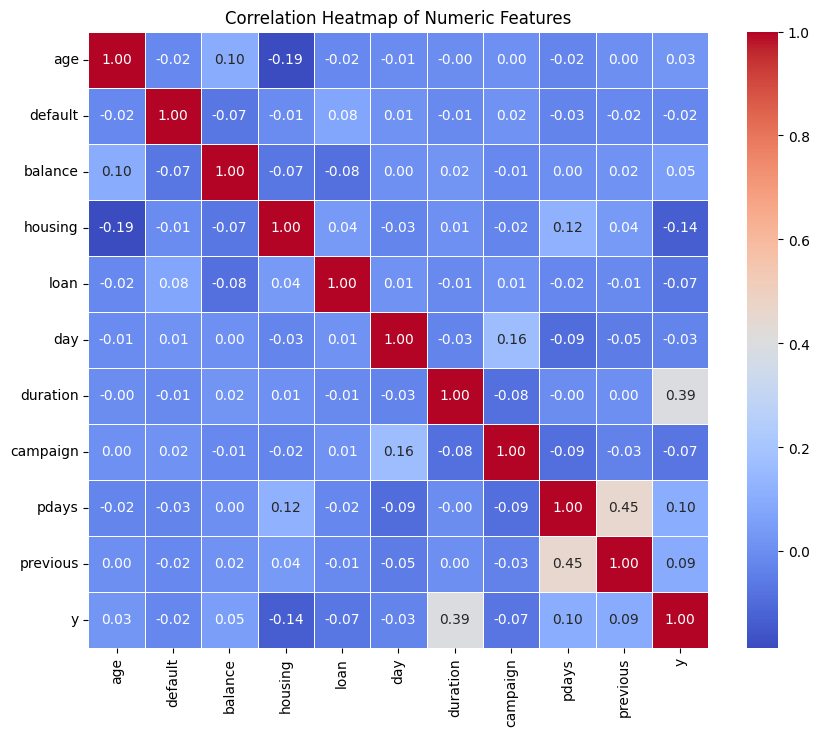

In [17]:
# Correlation heatmap for numeric features
plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()
